<a href="https://colab.research.google.com/github/sujay-dsa/ComputerVision/blob/master/Session_6/EVA5_session6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analysis of Regularization Techniques
We will analyze and compare the results of various regularization techniques l1,l2, l1+l2, ghost batch normalization, ghost batch normalization with l1+l2.

# Import Libraries

In [68]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [70]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1305,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1305,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [71]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [72]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
We'll use the model definition from step 6 of the last assignment

In [73]:
dropout_value = 0.09
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # CONVOLUTION BLOCK 1_1 ##padding layer
        self.convblock2_1 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock2_1(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

#### Define extra classes for ghost batch normalization

In [74]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias
        
class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

Write a new model definition for Ghost Batch Norm

In [75]:
class NetGBN(nn.Module):
    def __init__(self):
        super(NetGBN, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(10,1),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            GhostBatchNorm(10,1),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # CONVOLUTION BLOCK 1_1 ##padding layer
        self.convblock2_1 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(16,1),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            GhostBatchNorm(16,1),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            GhostBatchNorm(16,1),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            GhostBatchNorm(20,1),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock2_1(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [76]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 26, 26]             900
              ReLU-6           [-1, 10, 26, 26]               0
       BatchNorm2d-7           [-1, 10, 26, 26]              20
           Dropout-8           [-1, 10, 26, 26]               0
            Conv2d-9           [-1, 16, 24, 24]           1,440
             ReLU-10           [-1, 16, 24, 24]               0
      BatchNorm2d-11           [-1, 16, 24, 24]              32
          Dropout-12           [-1, 16, 24, 24]               0
           Conv2d-13           [-1, 10, 24, 24]             160
        MaxPool2d-14           [-1

Model summary for Ghost Batch Norm

In [77]:
model2 = NetGBN().to(device)
summary(model2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 26, 26]             900
              ReLU-6           [-1, 10, 26, 26]               0
    GhostBatchNorm-7           [-1, 10, 26, 26]              20
           Dropout-8           [-1, 10, 26, 26]               0
            Conv2d-9           [-1, 16, 24, 24]           1,440
             ReLU-10           [-1, 16, 24, 24]               0
   GhostBatchNorm-11           [-1, 16, 24, 24]              32
          Dropout-12           [-1, 16, 24, 24]               0
           Conv2d-13           [-1, 10, 24, 24]             160
        MaxPool2d-14           [-1, 10,

# Training and Testing

Define loss function for each of the regularization techniques we want to use

In [78]:
from tqdm import tqdm


gbn_misclassified_img=[]

In [79]:
def train(model, device, train_loader, optimizer, epoch,regularizer,losses_array, acc_array):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    
    # Predict
    y_pred = model(data)
    # Calculate loss
    loss = F.nll_loss(y_pred,target)
      
    
    l1=0
    for p in model.parameters():      
      l1=l1+p.abs().sum()
    
    lambda_l1=1e-5
    
    
    # Backpropagation

    # For l1
    #------------------
    if(regularizer=='l1'):
      loss=loss+lambda_l1*l1       
                
    


    # For l2 loss
    #------------------
    # Nothing needed as this is accomodated in the optimizer


    # For l1 and l2 loss
    #------------------
    if(regularizer=='l1l2'):
      loss=loss+lambda_l1*l1      
    
    

    # For GBN
    #------------------
    # No need to do anything as GBN is addressed in model definition


    # For GBN + l1l2 
    #------------------
    if(regularizer=='l1l2'):
      loss=loss+lambda_l1*l1      
    
    losses_array.append(loss)
    
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.
        
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
  
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Model={regularizer} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    acc_array.append(100*correct/processed)



In [80]:
incorrect_examples = []
predicted_img=[]
actual_targets=[]
def test(model, device, test_loader, test_losses, test_accuracies,regularizer):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target,reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            if(regularizer=='gbn'):
              _, imgpred = torch.max(output,1)
              idxs_mask = ((imgpred == target) == False).nonzero()
              incorrect_examples.append(data[idxs_mask].cpu().numpy())
              actual_targets.append(target.cpu().numpy())
              predicted_img.append(imgpred.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_accuracies.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [81]:
regularizers =['l1','l2','l1l2','gbn','gbnl1l2']
#regularizers =['gbn','gbnl1l2']

losses={}
accuracies={}

test_losses = {}
test_accuracies= {}

EPOCHS = 25
for regularizer in regularizers:
  model=None
  optimizer=None
  scheduler = None

  if(regularizer=='l1'):
    model= Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=7,gamma=0.2)
  
  if(regularizer=='l2'):
    model= Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9,weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=7,gamma=0.2)

  if(regularizer=='l1l2'):
    model= Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9,weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=7,gamma=0.2)

  if(regularizer=='gbn'):
    model = NetGBN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=7,gamma=0.2)

  if(regularizer=='gbnl1l2'):
    model=NetGBN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9,weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=7,gamma=0.2)
  
  losses[regularizer]=[]
  test_losses[regularizer]=[]
  accuracies[regularizer]=[]
  test_accuracies[regularizer]=[]
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch,regularizer,losses[regularizer],accuracies[regularizer])
      test(model, device, test_loader, test_losses[regularizer], test_accuracies[regularizer],regularizer)
      scheduler.step()

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Model=l1 Loss=0.05875135958194733 Batch_id=468 Accuracy=91.65: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0843, Accuracy: 9723/10000 (97.23%)

EPOCH: 1


Model=l1 Loss=0.12281187623739243 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:16<00:00, 28.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9853/10000 (98.53%)

EPOCH: 2


Model=l1 Loss=0.023547885939478874 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:16<00:00, 28.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9881/10000 (98.81%)

EPOCH: 3


Model=l1 Loss=0.054058004170656204 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:16<00:00, 28.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 9835/10000 (98.35%)

EPOCH: 4


Model=l1 Loss=0.016060879454016685 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:16<00:00, 28.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9888/10000 (98.88%)

EPOCH: 5


Model=l1 Loss=0.03453277796506882 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:16<00:00, 28.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9912/10000 (99.12%)

EPOCH: 6


Model=l1 Loss=0.07581431418657303 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:16<00:00, 28.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9898/10000 (98.98%)

EPOCH: 7


Model=l1 Loss=0.02539375051856041 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 28.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Model=l1 Loss=0.044244300574064255 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:16<00:00, 28.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9931/10000 (99.31%)

EPOCH: 9


Model=l1 Loss=0.018585754558444023 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:16<00:00, 28.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Model=l1 Loss=0.016033383086323738 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:16<00:00, 28.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9934/10000 (99.34%)

EPOCH: 11


Model=l1 Loss=0.021293584257364273 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:16<00:00, 29.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Model=l1 Loss=0.017466742545366287 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:16<00:00, 28.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9936/10000 (99.36%)

EPOCH: 13


Model=l1 Loss=0.029874183237552643 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:16<00:00, 28.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Model=l1 Loss=0.023651421070098877 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Model=l1 Loss=0.07499761134386063 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:16<00:00, 28.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9930/10000 (99.30%)

EPOCH: 16


Model=l1 Loss=0.04263153672218323 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 29.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9936/10000 (99.36%)

EPOCH: 17


Model=l1 Loss=0.017932850867509842 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 29.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9936/10000 (99.36%)

EPOCH: 18


Model=l1 Loss=0.014194250106811523 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:16<00:00, 29.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9939/10000 (99.39%)

EPOCH: 19


Model=l1 Loss=0.030527513474225998 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9936/10000 (99.36%)

EPOCH: 20


Model=l1 Loss=0.043012745678424835 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:16<00:00, 29.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9936/10000 (99.36%)

EPOCH: 21


Model=l1 Loss=0.05052530765533447 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 29.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)

EPOCH: 22


Model=l1 Loss=0.01715685985982418 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:16<00:00, 29.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9936/10000 (99.36%)

EPOCH: 23


Model=l1 Loss=0.03047506883740425 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:16<00:00, 29.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.41%)

EPOCH: 24


Model=l1 Loss=0.05480431392788887 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:16<00:00, 29.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9937/10000 (99.37%)

EPOCH: 0


Model=l2 Loss=0.1476096659898758 Batch_id=468 Accuracy=91.40: 100%|██████████| 469/469 [00:15<00:00, 29.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0695, Accuracy: 9792/10000 (97.92%)

EPOCH: 1


Model=l2 Loss=0.16701261699199677 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:15<00:00, 30.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9859/10000 (98.59%)

EPOCH: 2


Model=l2 Loss=0.044715553522109985 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:15<00:00, 29.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9905/10000 (99.05%)

EPOCH: 3


Model=l2 Loss=0.1363966017961502 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:15<00:00, 29.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9902/10000 (99.02%)

EPOCH: 4


Model=l2 Loss=0.1031436026096344 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:15<00:00, 29.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Model=l2 Loss=0.034502413123846054 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:15<00:00, 29.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9933/10000 (99.33%)

EPOCH: 6


Model=l2 Loss=0.02927180379629135 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:15<00:00, 29.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Model=l2 Loss=0.013386805541813374 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:16<00:00, 29.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9942/10000 (99.42%)

EPOCH: 8


Model=l2 Loss=0.01577385701239109 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:15<00:00, 30.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9947/10000 (99.47%)

EPOCH: 9


Model=l2 Loss=0.021682024002075195 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Model=l2 Loss=0.011550094932317734 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 30.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9946/10000 (99.46%)

EPOCH: 11


Model=l2 Loss=0.0329914391040802 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 30.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


Model=l2 Loss=0.03602725639939308 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 30.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


Model=l2 Loss=0.033742453902959824 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 30.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


Model=l2 Loss=0.01990550383925438 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 30.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

EPOCH: 15


Model=l2 Loss=0.017967762425541878 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 30.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9949/10000 (99.49%)

EPOCH: 16


Model=l2 Loss=0.002369625261053443 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:15<00:00, 30.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9949/10000 (99.49%)

EPOCH: 17


Model=l2 Loss=0.018056267872452736 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:15<00:00, 30.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9951/10000 (99.51%)

EPOCH: 18


Model=l2 Loss=0.00654250755906105 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:15<00:00, 30.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)

EPOCH: 19


Model=l2 Loss=0.009644933044910431 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9946/10000 (99.46%)

EPOCH: 20


Model=l2 Loss=0.014694561250507832 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:15<00:00, 30.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9948/10000 (99.48%)

EPOCH: 21


Model=l2 Loss=0.02938617765903473 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:15<00:00, 30.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9948/10000 (99.48%)

EPOCH: 22


Model=l2 Loss=0.015664074569940567 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:15<00:00, 30.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9949/10000 (99.49%)

EPOCH: 23


Model=l2 Loss=0.008913138881325722 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9950/10000 (99.50%)

EPOCH: 24


Model=l2 Loss=0.008426983840763569 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9947/10000 (99.47%)

EPOCH: 0


Model=l1l2 Loss=0.06167134270071983 Batch_id=468 Accuracy=92.20: 100%|██████████| 469/469 [00:15<00:00, 29.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0716, Accuracy: 9787/10000 (97.87%)

EPOCH: 1


Model=l1l2 Loss=0.09400255978107452 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:15<00:00, 29.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9866/10000 (98.66%)

EPOCH: 2


Model=l1l2 Loss=0.05203717574477196 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:16<00:00, 28.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9904/10000 (99.04%)

EPOCH: 3


Model=l1l2 Loss=0.05704941973090172 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Model=l1l2 Loss=0.02837834507226944 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:16<00:00, 28.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9887/10000 (98.87%)

EPOCH: 5


Model=l1l2 Loss=0.06437534093856812 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9902/10000 (99.02%)

EPOCH: 6


Model=l1l2 Loss=0.036673516035079956 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:16<00:00, 29.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9909/10000 (99.09%)

EPOCH: 7


Model=l1l2 Loss=0.048370324075222015 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:16<00:00, 28.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9934/10000 (99.34%)

EPOCH: 8


Model=l1l2 Loss=0.07774575799703598 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 29.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Model=l1l2 Loss=0.0632878765463829 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Model=l1l2 Loss=0.03388563543558121 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:16<00:00, 29.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Model=l1l2 Loss=0.03503379598259926 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 28.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Model=l1l2 Loss=0.035581156611442566 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:15<00:00, 29.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Model=l1l2 Loss=0.03023373708128929 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 29.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Model=l1l2 Loss=0.021854359656572342 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:16<00:00, 28.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Model=l1l2 Loss=0.12478399276733398 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:16<00:00, 29.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9936/10000 (99.36%)

EPOCH: 16


Model=l1l2 Loss=0.03174082934856415 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:15<00:00, 29.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Model=l1l2 Loss=0.04110373556613922 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:16<00:00, 28.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Model=l1l2 Loss=0.04147568717598915 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:16<00:00, 28.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9938/10000 (99.38%)

EPOCH: 19


Model=l1l2 Loss=0.03023545816540718 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:15<00:00, 29.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9936/10000 (99.36%)

EPOCH: 20


Model=l1l2 Loss=0.019629057496786118 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:15<00:00, 29.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9933/10000 (99.33%)

EPOCH: 21


Model=l1l2 Loss=0.10416879504919052 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9937/10000 (99.37%)

EPOCH: 22


Model=l1l2 Loss=0.025445394217967987 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:16<00:00, 29.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9937/10000 (99.37%)

EPOCH: 23


Model=l1l2 Loss=0.02567133866250515 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9934/10000 (99.34%)

EPOCH: 24


Model=l1l2 Loss=0.025083493441343307 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:16<00:00, 29.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9931/10000 (99.31%)

EPOCH: 0


Model=gbn Loss=0.02630387805402279 Batch_id=468 Accuracy=91.53: 100%|██████████| 469/469 [00:15<00:00, 30.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0706, Accuracy: 9800/10000 (98.00%)

EPOCH: 1


Model=gbn Loss=0.045654911547899246 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:15<00:00, 30.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9838/10000 (98.38%)

EPOCH: 2


Model=gbn Loss=0.023192815482616425 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:15<00:00, 30.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9875/10000 (98.75%)

EPOCH: 3


Model=gbn Loss=0.03620227053761482 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:15<00:00, 30.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9891/10000 (98.91%)

EPOCH: 4


Model=gbn Loss=0.08162891119718552 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:15<00:00, 30.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9885/10000 (98.85%)

EPOCH: 5


Model=gbn Loss=0.02189881168305874 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:15<00:00, 30.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9892/10000 (98.92%)

EPOCH: 6


Model=gbn Loss=0.04226098954677582 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:15<00:00, 30.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9905/10000 (99.05%)

EPOCH: 7


Model=gbn Loss=0.00333299208432436 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:15<00:00, 29.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Model=gbn Loss=0.005780346691608429 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:15<00:00, 30.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Model=gbn Loss=0.004782979842275381 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 29.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Model=gbn Loss=0.05679132044315338 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 30.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Model=gbn Loss=0.003665714291855693 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:15<00:00, 30.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Model=gbn Loss=0.03092990815639496 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 30.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Model=gbn Loss=0.030273735523223877 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:15<00:00, 30.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Model=gbn Loss=0.02477867342531681 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9934/10000 (99.34%)

EPOCH: 15


Model=gbn Loss=0.048971954733133316 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9938/10000 (99.38%)

EPOCH: 16


Model=gbn Loss=0.0787261426448822 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 29.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9936/10000 (99.36%)

EPOCH: 17


Model=gbn Loss=0.06062176451086998 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:16<00:00, 28.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9938/10000 (99.38%)

EPOCH: 18


Model=gbn Loss=0.0074765621684491634 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 30.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9935/10000 (99.35%)

EPOCH: 19


Model=gbn Loss=0.026433797553181648 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 30.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9935/10000 (99.35%)

EPOCH: 20


Model=gbn Loss=0.0050756074488162994 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 30.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Model=gbn Loss=0.00472158333286643 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 30.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Model=gbn Loss=0.014940527267754078 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 30.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

EPOCH: 23


Model=gbn Loss=0.0065129417926073074 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9929/10000 (99.29%)

EPOCH: 24


Model=gbn Loss=0.00937254261225462 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:15<00:00, 30.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9932/10000 (99.32%)

EPOCH: 0


Model=gbnl1l2 Loss=0.03726908192038536 Batch_id=468 Accuracy=91.74: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0676, Accuracy: 9786/10000 (97.86%)

EPOCH: 1


Model=gbnl1l2 Loss=0.09803691506385803 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:15<00:00, 30.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 9845/10000 (98.45%)

EPOCH: 2


Model=gbnl1l2 Loss=0.10121938586235046 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:15<00:00, 29.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9890/10000 (98.90%)

EPOCH: 3


Model=gbnl1l2 Loss=0.012695175595581532 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9917/10000 (99.17%)

EPOCH: 4


Model=gbnl1l2 Loss=0.012465562671422958 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:15<00:00, 29.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9926/10000 (99.26%)

EPOCH: 5


Model=gbnl1l2 Loss=0.009516223333775997 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:15<00:00, 29.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9919/10000 (99.19%)

EPOCH: 6


Model=gbnl1l2 Loss=0.04912066459655762 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:15<00:00, 29.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9929/10000 (99.29%)

EPOCH: 7


Model=gbnl1l2 Loss=0.017515869811177254 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:15<00:00, 29.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9929/10000 (99.29%)

EPOCH: 8


Model=gbnl1l2 Loss=0.023678207769989967 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 30.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9938/10000 (99.38%)

EPOCH: 9


Model=gbnl1l2 Loss=0.011457856744527817 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 29.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9939/10000 (99.39%)

EPOCH: 10


Model=gbnl1l2 Loss=0.031737979501485825 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 30.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9944/10000 (99.44%)

EPOCH: 11


Model=gbnl1l2 Loss=0.010378987528383732 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 30.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9945/10000 (99.45%)

EPOCH: 12


Model=gbnl1l2 Loss=0.0030946473125368357 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 29.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9947/10000 (99.47%)

EPOCH: 13


Model=gbnl1l2 Loss=0.020482875406742096 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 29.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9943/10000 (99.43%)

EPOCH: 14


Model=gbnl1l2 Loss=0.031168729066848755 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 29.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9945/10000 (99.45%)

EPOCH: 15


Model=gbnl1l2 Loss=0.013272427953779697 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 30.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9942/10000 (99.42%)

EPOCH: 16


Model=gbnl1l2 Loss=0.0017207664204761386 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:15<00:00, 30.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9945/10000 (99.45%)

EPOCH: 17


Model=gbnl1l2 Loss=0.065822072327137 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:15<00:00, 29.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9944/10000 (99.44%)

EPOCH: 18


Model=gbnl1l2 Loss=0.018760032951831818 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:15<00:00, 29.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9942/10000 (99.42%)

EPOCH: 19


Model=gbnl1l2 Loss=0.016877001151442528 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9945/10000 (99.45%)

EPOCH: 20


Model=gbnl1l2 Loss=0.010646314360201359 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:15<00:00, 29.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9947/10000 (99.47%)

EPOCH: 21


Model=gbnl1l2 Loss=0.06273020058870316 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:15<00:00, 30.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9944/10000 (99.44%)

EPOCH: 22


Model=gbnl1l2 Loss=0.00845212023705244 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:15<00:00, 30.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9947/10000 (99.47%)

EPOCH: 23


Model=gbnl1l2 Loss=0.005499433726072311 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 29.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9949/10000 (99.49%)

EPOCH: 24


Model=gbnl1l2 Loss=0.005008839536458254 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:15<00:00, 30.01it/s]



Test set: Average loss: 0.0175, Accuracy: 9945/10000 (99.45%)



In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

print(test_accuracies.keys())
model1_acc_hist = test_accuracies['l1']
model2_acc_hist = test_accuracies['l2']
model3_acc_hist = test_accuracies['l1l2']
model4_acc_hist = test_accuracies['gbn']
model5_acc_hist = test_accuracies['gbnl1l2']

model1_loss_hist = test_losses['l1']
model2_loss_hist = test_losses['l2']
model3_loss_hist = test_losses['l1l2']
model4_loss_hist = test_losses['gbn']
model5_loss_hist = test_losses['gbnl1l2']



def plot_model_comparison(legend_list, model1_acc_hist, model1_loss_hist,
                          model2_acc_hist, model2_loss_hist,
                          model3_acc_hist, model3_loss_hist,
                          model4_acc_hist, model4_loss_hist,
                          model5_acc_hist, model5_loss_hist):
    fig, axs = plt.subplots(1,2,figsize=(20,5))
    # summarize history for accuracy
    x_size = len(model1_acc_hist)-1

    axs[0].plot(range(1,x_size+1), model1_acc_hist[1:])
    axs[0].plot(range(1,x_size+1), model2_acc_hist[1:])
    axs[0].plot(range(1,x_size+1), model3_acc_hist[1:])
    axs[0].plot(range(1,x_size+1), model4_acc_hist[1:])
    axs[0].plot(range(1,x_size+1), model5_acc_hist[1:])

    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,x_size+1),x_size/10)
    axs[0].legend(legend_list, loc='best')

   # plot losses
    axs[1].plot(range(1,x_size+1),model1_loss_hist[1:])
    axs[1].plot(range(1,x_size+1),model2_loss_hist[1:])
    axs[1].plot(range(1,x_size+1),model3_loss_hist[1:])
    axs[1].plot(range(1,x_size+1),model4_loss_hist[1:])
    axs[1].plot(range(1,x_size+1),model5_loss_hist[1:])
    axs[1].set_title('Model Losses')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,x_size+1),x_size/10)
    axs[1].legend(legend_list, loc='best')
    plt.show()
    fig.savefig("model_compare.png")

dict_keys(['l1', 'l2', 'l1l2', 'gbn', 'gbnl1l2'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


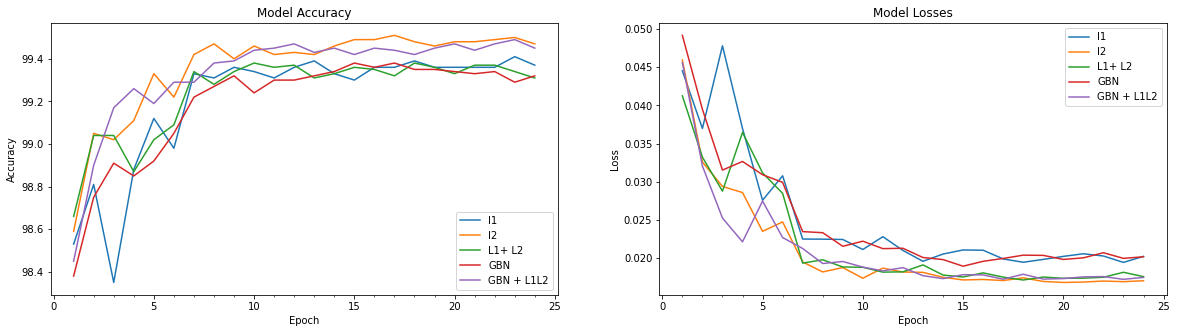

In [83]:
legend_list = ["l1", "l2", "L1+ L2", "GBN","GBN + L1L2"]
plot_model_comparison(legend_list,
                      model1_acc_hist, model1_loss_hist,
                      model2_acc_hist, model2_loss_hist,
                      model3_acc_hist, model3_loss_hist,
                      model4_acc_hist, model4_loss_hist,
                      model5_acc_hist, model5_loss_hist)

1975


IndexError: ignored

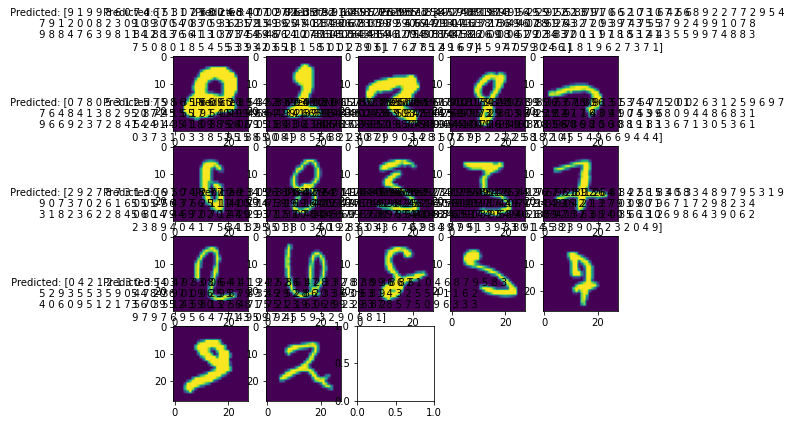

In [134]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5

print(len(incorrect_examples))
for i in range(1, rows*columns +1):
    img = incorrect_examples[i]
    # img = img/2 + 0.5
    # img = np.clip(img, 0, 1)
    fig.add_subplot(rows, columns, i)
    plt.imshow( img[0][0][0])
    plt.title(' Predicted: '+str(predicted_img[i]), fontsize = 10)
plt.show()



  